In [1]:
from tqdm import tqdm
from workflow.fastani.remove_gunc_failed_contigs_by_contamination_sp_cluster import RemoveGuncFailedContigsByContaminationSpCluster
from workflow.config import PCT_VALUES
from workflow.external.gtdb_metadata import GtdbMetadataR207

In [2]:
DF = RemoveGuncFailedContigsByContaminationSpCluster().output().read_cached()
print(DF.shape)

UNQ_GIDS = set(DF.index.get_level_values(0))

print(f'{len(UNQ_GIDS):,} failed gids')
DF.head()

(578539, 5)
35,723 failed gids


new_sp_rep      ani        af    type  same
gid             pct                                                  
GCA_000143435.1 1    GCF_001435955.1  97.3270  0.875591  sp_rep  True
                5    GCF_001435955.1  97.3270  0.875591  sp_rep  True
                15   GCF_001435955.1  97.6349  0.829228  sp_rep  True
GCA_000153745.1 5                NaN      NaN       NaN  no_ani  True
GCA_000155005.1 1    GCF_003697165.2  96.5203  0.827668  sp_rep  True

In [3]:
from workflow.external.gtdb_metadata import GtdbMetadataR207

DF_META = GtdbMetadataR207().output().read_cached()
DF_META.head()

,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,contig_count,...,gtdb_type_species_of_genus,ncbi_taxonomy,ncbi_taxonomy_unfiltered,domain,phylum,class,order,family,genus,species
gid,,,,,,,,,,,,,,,,,,,,,
GCA_000006155.2,1916,93.12,0.0,1171,g__Bacillus (UID902),324,0.0,4305660,80.178992,426,...,f,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,d__Bacteria;x__Terrabacteria group;p__Firmicut...,d__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae_G,g__Bacillus_A,s__Bacillus_A anthracis
GCA_000007325.1,1,99.95,0.0,149,k__Bacteria (UID2329),89,0.0,1973459,90.754610,1,...,t,d__Bacteria;p__Fusobacteria;c__Fusobacteriia;o...,d__Bacteria;p__Fusobacteria;c__Fusobacteriia;o...,d__Bacteria,p__Fusobacteriota,c__Fusobacteriia,o__Fusobacteriales,f__Fusobacteriaceae,g__Fusobacterium,s__Fusobacterium nucleatum
GCA_000007385.1,0,99.82,0.0,481,c__Gammaproteobacteria (UID4202),276,0.0,4190634,84.805944,1,...,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Xanthomonadales,f__Xanthomonadaceae,g__Xanthomonas,s__Xanthomonas oryzae
GCA_000008085.1,0,73.13,0.0,149,k__Archaea (UID2),107,0.0,462902,94.299480,1,...,t,d__Archaea;p__Nanoarchaeota;c__;o__Nanoarchaea...,d__Archaea;x__DPANN group;p__Nanoarchaeota;o__...,d__Archaea,p__Nanoarchaeota,c__Nanoarchaeia,o__Nanoarchaeales,f__Nanoarchaeaceae,g__Nanoarchaeum,s__Nanoarchaeum equitans
GCA_000008885.1,0,100.00,0.0,134,k__Bacteria (UID2495),80,0.0,617456,87.831079,2,...,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales_A,f__Enterobacteriaceae_A,g__Wigglesworthia,s__Wigglesworthia glossinidia_A


In [14]:
from workflow.bootstrap.remove_random_contigs_for_bootstrap_rep_analysis import RemoveRandomContigsForBootstrapRepAnalysis

DF_BS = RemoveRandomContigsForBootstrapRepAnalysis().output().read_cached()
DF_BS['source'] = 'bootstrap'
DF_BS.head()

,pct,change,count,source
0,1,Species clusters merged,4.2,bootstrap
7,10,Species clusters merged,3.9,bootstrap
20,40,Species clusters merged,6.3,bootstrap
17,30,Species clusters merged,6.4,bootstrap
14,20,Species clusters merged,4.2,bootstrap


types:
no_af = no alignment fraction <0.5
no_ani = novel species cluster
sp_rep = found species representative within ANI radius


In [4]:
from collections import defaultdict


def gen_data():

    # Some were originally run with more pct values, but just reduce to the analysis set
    df_changed = DF[DF['same'] == False]
    df_changed = df_changed.reset_index()
    df_changed = df_changed[df_changed['pct'].isin(PCT_VALUES)]

    d_pct_to_changes = defaultdict(list)

    for cur_pct in PCT_VALUES:
        df_subset = df_changed[df_changed['pct'] == cur_pct]

        for _, row in df_subset.iterrows():
            gid = row['gid']

            meta_row = DF_META.loc[gid]
            is_rep = meta_row['gtdb_representative'] == 't'

            if is_rep:
                change_type = 'representative changed species'
            else:
                if row['type'] == 'no_af' or row['type'] == 'no_ani':
                    change_type = 'novel_sp_cluster'
                else:
                    change_type = 'species changed'

            d_pct_to_changes[cur_pct].append(change_type)

    return d_pct_to_changes

data = gen_data()


145
33


1 19
5 30
10 55
15 77
20 90
30 115
40 139
50 178


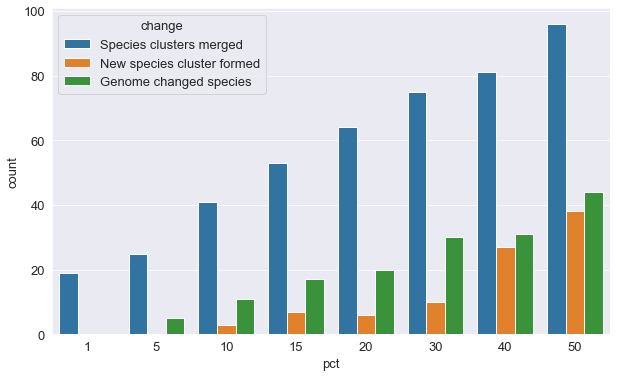

In [61]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
def make_plot():

    rows = list()

    for k, v in data.items():
        print(k, len(v))
        cnts = Counter(v)
        rows.append({
            'pct': k,
            'change': 'Species clusters merged',
            'count': cnts.get('representative changed species', 0),
            'source': 'fail'
        })
        rows.append({
            'pct': k,
            'change': 'New species cluster formed',
            'count': cnts.get('novel_sp_cluster', 0),
            'source': 'fail'
        })
        rows.append({
            'pct': k,
            'change': 'Genome changed species',
            'count': cnts.get('species changed', 0),
            'source': 'fail'
        })

    df = pd.DataFrame(rows)


    df_merged = pd.concat([df, DF_BS], ignore_index=True)
    df_merged.sort_values(by=['pct'], inplace=True)

    df_f_changed_sp = df_merged[(df_merged['source'] == 'fail') & (df_merged['change'] == 'Genome changed species')]
    df_b_changed_sp = df_merged[(df_merged['source'] == 'bootstrap') & (df_merged['change'] == 'Genome changed species')]

    df_f_merged_sp = df_merged[(df_merged['source'] == 'fail') & (df_merged['change'] == 'Species clusters merged')]
    df_b_merged_sp = df_merged[(df_merged['source'] == 'bootstrap') & (df_merged['change'] == 'Species clusters merged')]


    df_f_new = df_merged[(df_merged['source'] == 'fail') & (df_merged['change'] == 'New species cluster formed')]
    df_b_new = df_merged[(df_merged['source'] == 'bootstrap') & (df_merged['change'] == 'New species cluster formed')]



    fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
    plt.rcParams.update({'font.size': 13})
    plt.rcParams['svg.fonttype'] = 'none'

    hue_order = ['Species clusters merged', 'New species cluster formed', 'Genome changed species']
    sns.barplot(data=df_merged[df_merged['source'] == 'fail'], x='pct', y='count', hue='change',
                hue_order=hue_order)
    # sns.barplot(data=df_merged[df_merged['source'] == 'bootstrap'], x='pct', y='count', hue='change',
    #             palette="Blues_d", hue_order=hue_order)

    # ax1.plot(df_f_changed_sp['pct'], df_f_changed_sp['count'], marker='o', label='Putatively contaminated')
    # ax1.plot(df_b_changed_sp['pct'], df_b_changed_sp['count'], '--', marker='o', label='Background')
    #
    # ax1.plot(df_f_merged_sp['pct'], df_f_merged_sp['count'], marker='o', label='Putatively contaminated')
    # ax1.plot(df_b_merged_sp['pct'], df_b_merged_sp['count'],  '--', marker='o', label='Background')
    #
    # ax1.plot(df_f_new['pct'], df_f_new['count'], marker='o', label='Putatively contaminated')
    # ax1.plot(df_b_new['pct'], df_b_new['count'], '--', marker='o',   label='Background')
    #
    # ax1.set_xticks(PCT_VALUES)
    #
    # ax1.set_title('Species clusters merged')
    #
    # ax1.set_ylim(-2, 100)
    #
    # plt.legend()

    plt.savefig('/tmp/new_breakdown.svg')


    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))
    # plt.rcParams.update({'font.size': 13})
    # plt.rcParams['svg.fonttype'] = 'none'
    #
    # ax3.plot(df_f_changed_sp['pct'], df_f_changed_sp['count'], marker='o', label='Putatively contaminated')
    # ax3.plot(df_b_changed_sp['pct'], df_b_changed_sp['count'], marker='o', label='Background')
    #
    # ax1.plot(df_f_merged_sp['pct'], df_f_merged_sp['count'], marker='o', label='Putatively contaminated')
    # ax1.plot(df_b_merged_sp['pct'], df_b_merged_sp['count'], marker='o', label='Background')
    #
    # ax2.plot(df_f_new['pct'], df_f_new['count'], marker='o', label='Putatively contaminated')
    # ax2.plot(df_b_new['pct'], df_b_new['count'], marker='o', label='Background')
    #
    # ax1.set_xticks(PCT_VALUES)
    # ax2.set_xticks(PCT_VALUES)
    # ax3.set_xticks(PCT_VALUES)
    #
    # ax1.set_title('Species clusters merged')
    # ax2.set_title('New species cluster formed')
    # ax3.set_title('Genome changed species')
    #
    # ax1.set_ylim(-2, 100)
    # ax2.set_ylim(-2, 40)
    # ax3.set_ylim(-2, 50)
    #
    # plt.legend()
    #
    # plt.savefig('/tmp/new_breakdown.svg')

    return

    # df = df[df['pct'] <= 10]
    # df['value'] = df['value']


    fig, ax = plt.subplots(figsize=(15, 10))

    plt.rcParams['svg.fonttype'] = 'none'

    ax.grid(True)
    plt.rcParams.update({'font.size': 18})
    sns.barplot(data=df, x='pct', y='value', hue='Type of change', ax=ax)
    ax.set_ylabel('Number of putatively contaminated genomes affected')
    ax.set_xlabel('% of genome removed')

    ax.set_yticks(list(range(0, 110, 10)))

    plt.title('Number of putatively contaminated genomes affected by percentage of genome removed')

    plt.savefig('/tmp/sp_clustering_changes.svg')


    # ax.set_xticks(list(range(120, 10)))
    # ax.set_xticklabels(list(range(120, 10)))

    return



make_plot()